# <center>Data Mining Project Code</center>

** **
## <center>*02 - XXXXXXXX*</center>

** **

Consumers today are becoming more selective about where they buy their products and where they spend their money. Consequently, it is essencial for companies to better understand their clients, being able to tailor sales and discounts to certain groups of customers.

Knowing this, the goal of this project is to divide customers of `ABCDEats Inc.` into smaller groups, whose clients have similar characteristics and purchasing behaviours.

The second  notebook of this project consists of the .......

This project was presented to the `TargetSphere Advisors`, a group of Consultants, Business Analysts and Data Scientists who focus on delivering Customer Segementation solutions for small and medium-sized businesses.

The members of the `team` are:
- Ana Farinha  - 20211514
- António Oliveira - 20211595
- Mariana Neto - 20211527
- Salvador Domingues - 20240597


# Table of Contents

<a class="anchor" id="top"></a>


1. [Importing Libraries & Data](#1.-Importing-Libraries-&-Data) <br><br>
2. [Data Cleansing](#2.-Data-Cleansing) <br><br>
    2.1 [Filling the missing values](#2.1-Filling-the-missing-values) <br><br>
    2.2 [Outlier Treatment](#2.2-Outlier-Treatment)<br><br>
3. [Feature Selection](#-3.-Feature-Selection)<br><br>
    3.1 [Univariate variables](#3.1.-Univariate-variables)<br><br>
    3.2 [Spearman Correlation](#3.2-Spearman-Correlation)


 

# 1. Importing Libraries & Data

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# To fill the missing values
from sklearn.impute import KNNImputer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Import external '.py' file containing the functions created and used for this analysis
import functions as f

In [3]:
dataset_name = 'preprocessed_data'

data = pd.read_csv(f'data/{dataset_name}.csv', index_col = "customer_id")
data.head(3)

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,avg_order_hour,total_spend,avg_spend_prod,is_repeat_customer,weekend_orders,weekday_orders,0_7h,8_14h,15_19h,20_23h
customer_id,,,,,,,,,,,,,,,,,,,,,
1b8f824d5e,2360,18.0,2,5,1,0,1,DELIVERY,DIGI,0.00,...,18.0,28.88,5.776,1,2,0,0,0,2,0
5d272b9dcb,8670,17.0,2,2,2,0,1,DISCOUNT,DIGI,12.82,...,10.5,19.21,9.605,1,2,0,0,2,0,0
f6d1b2ba63,4660,38.0,1,2,2,0,1,DISCOUNT,CASH,9.20,...,10.0,9.20,4.600,1,2,0,0,2,0,0


In [4]:
data['customer_region'] = data['customer_region'].replace(0, '0000')

In [5]:
data['customer_region'] = data['customer_region'].astype(str)

In [6]:
data['customer_region'].unique()

array(['2360', '8670', '4660', '2440', '0000', '4140', '2490', '8370',
       '8550'], dtype=object)

<br>

# 2. Data Cleansing

## 2.1 Filling the missing values

In the previous notebook, we noticed that there were 3 columns with missing values: `customer_age`, `first_order` and `HR_0`. For the feature `first_order` we considered filling the missing values with 0, given that in these rows the last order had values of 0, meaning that the customer made their first and last order on the day that the dataset started. The last variable was deleted, since new features were created. Previously, we used the median for the feature `customer_age`, but in this notebook we will fill with the K nearest neighbor imputer.

In [7]:
data.isna().sum()

customer_region    0
customer_age       0
vendor_count       0
product_count      0
is_chain           0
                  ..
weekday_orders     0
0_7h               0
8_14h              0
15_19h             0
20_23h             0
Length: 76, dtype: int64

From the output above we can see that there are missing values in `avg_order_hour` and `days_between`, the reason for this is because for 235 customers there is no values in the hours feature.

**customer_age**

First, we are going to check the variables that have a higher correlation with `customer_age`. Doing this, we can use these variables to predict the missing value using the KNN Imputer.

In [8]:
numeric_data = data.select_dtypes(include=['int64', 'float64'])
final_data = numeric_data.loc[:, ~(numeric_data.isin([0, 1]).all())]

corr = final_data.corr(method="pearson")

# Selecting correlations for 'customer_age'
target_variable = 'customer_age'
if target_variable in corr:
    correlations = corr[target_variable].dropna()

    most_correlated = correlations.abs().sort_values(ascending=False)

    print("Most correlated variables with customer_age:")
    print(most_correlated)
else:
    print(f"'{target_variable}' is not in the numeric dataset.")

Most correlated variables with customer_age:
customer_age    1.000000
CUI_Asian       0.013063
DOW_0           0.012938
last_order      0.012150
total_spend     0.008660
                  ...   
HR_10           0.000557
HR_1            0.000429
HR_2            0.000379
DOW_6           0.000258
HR_9            0.000003
Name: customer_age, Length: 64, dtype: float64


In [9]:
# Selecting the top 6 correlated variables
top_correlated = most_correlated[1:7].index.tolist()

# Creating a new DataFrame with only the most correlated variables
selected_data = data[top_correlated + ['customer_age']]

# Applying KNN Imputer only to these variables
knn_imputer = KNNImputer(n_neighbors=10)
imputed_data = knn_imputer.fit_transform(selected_data)

# Replacing the imputed values in the original DataFrame
data['customer_age'] = imputed_data[:, selected_data.columns.get_loc('customer_age')].round().astype(int)

In [10]:
data['customer_age'].isna().sum()

0

<br>

**first_order**

Given the insights taken on the previous notebook, we will replace all missing values of the feature `first_order` to 0.

In [11]:
data['first_order'] = data['first_order'].fillna(0)

<br>

**days_between**

Since the days_between variable has missing values due to first_order, and we filled the missing values in first_order with 0, the days_between will also be 0, as the last_order is 0 when first_order was initially missing.

In [12]:
data['days_between'] = data['days_between'].fillna(0)

<br>

**avg_order_hour**

In [13]:
numeric_data = data.select_dtypes(include=['int64', 'float64'])
final_data = numeric_data.loc[:, ~(numeric_data.isin([0, 1]).all())]

corr = final_data.corr(method="pearson")

# Selecting correlations for 'avg_order_hour'
target_variable = 'avg_order_hour'
if target_variable in corr:
    correlations = corr[target_variable].dropna()

    # Sorting in descending order by absolute value
    most_correlated = correlations.abs().sort_values(ascending=False)

    print("Most correlated variables with avg_order_hour:")
    print(most_correlated)
else:
    print(f"'{target_variable}' is not in the numeric dataset.")

Most correlated variables with avg_order_hour:
avg_order_hour    1.000000
0_7h              0.529407
avg_spend_prod    0.400857
HR_3              0.367957
15_19h            0.362829
                    ...   
DOW_1             0.015230
last_order        0.009945
DOW_0             0.007197
customer_age      0.006522
CUI_Cafe          0.003192
Name: avg_order_hour, Length: 64, dtype: float64


In [14]:
# Selecting the top 5 correlated variables 
top_correlated = most_correlated[1:6].index.tolist()

# Creating a new DataFrame with only the most correlated variables
selected_data = data[top_correlated + ['avg_order_hour']]

# Applying KNN Imputer only to these variables
knn_imputer = KNNImputer(n_neighbors=10)
imputed_data = knn_imputer.fit_transform(selected_data)

# Replacing the imputed values in the original DataFrame
data['avg_order_hour'] = imputed_data[:, selected_data.columns.get_loc('avg_order_hour')]

In [15]:
print(data['avg_order_hour'].isna().sum())

0


<br>

## 2.2 Outlier Treatment

##### Solution A - do not apply any treatment. 

In this solution, no treatment will be applied. This will allow us to test different scalers. One of the reasons to do this, is to test it with the Robust scaler, which essentially caps the outliers.

In [16]:
data_copy = data.copy()

<br>

##### Solution B - Capping outliers

In [17]:
numeric_data = data_copy.select_dtypes(include='number')
categorical_data = data_copy.select_dtypes(include='object')
boolean_columns = numeric_data.loc[:, numeric_data.isin([0, 1]).all()]

data_no_booleans = numeric_data.loc[:, ~(numeric_data.isin([0, 1]).all())].copy()

From the visualizations ploted in the previous notebook, we noticed that none of the features have a normal distribution. By considering this, we are going to use the interquartile range method to cap the outliers.

In [18]:
f.cap_outliers(data_no_booleans)

In [19]:
data_capped = pd.concat([data_no_booleans, categorical_data, boolean_columns], axis=1)

<br>

##### Solution C - logarithmic tranformation

In [20]:
data_no_bool = numeric_data.loc[:, ~(numeric_data.isin([0, 1]).all())].copy()

ValueError: num must be an integer with 1 <= num <= 36, not 37

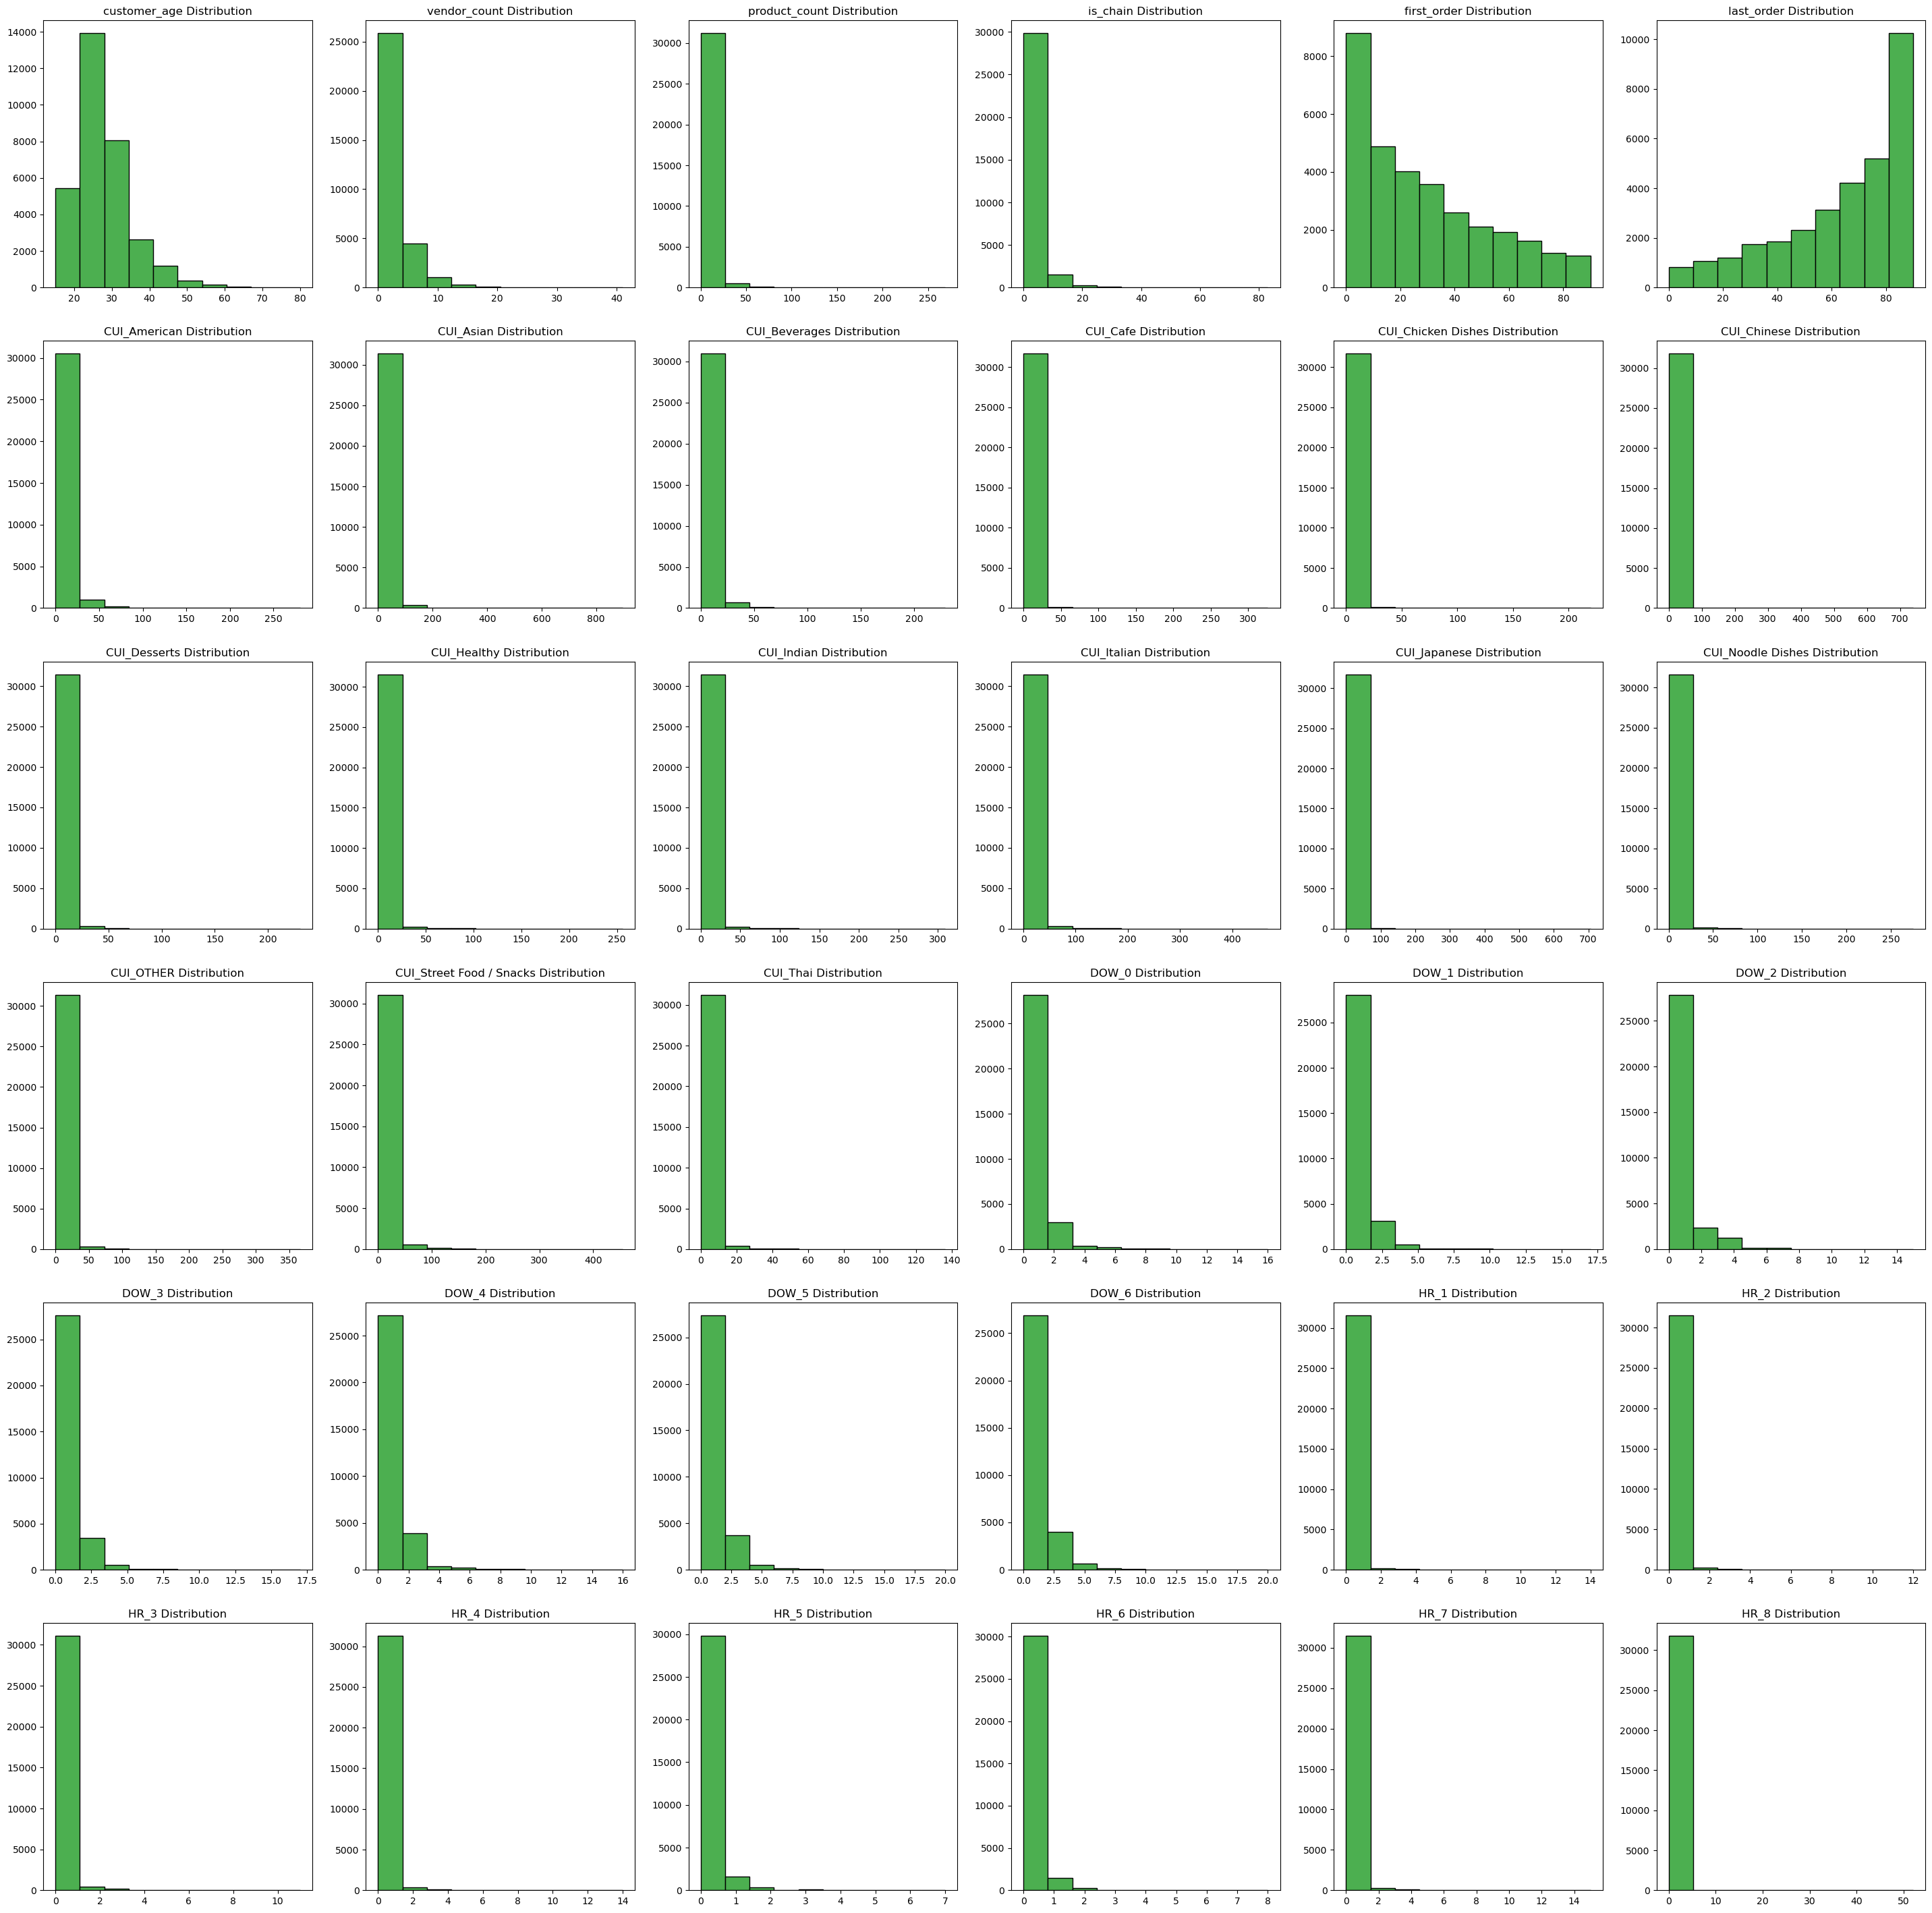

In [21]:
f.draw_histograms(data_no_bool, data_no_bool.columns, 6, 6)

From the plot below, it is clear that most of the numeric features have a Log-normal distribution, some exceptions are 

- `customer_age`: gamma distribution
- `days_between`, `first_order` and `last_order`: exponential distribution
- `avg_order_hour`:
- `avg_spend_prod`: 

Therefore, we will aply the logarithm to those features.

In [22]:
data_no_bool['customer_age'] = np.log10(data_no_bool['customer_age'])
data_no_bool['days_between'] = np.log10(data_no_bool['days_between'] + 1)
data_no_bool['first_order'] = np.log10(data_no_bool['first_order'] + 1)
data_no_bool['last_order'] = np.log10(data_no_bool['last_order'] + 1)
data_no_bool['avg_order_hour'] = np.log10(data_no_bool['avg_order_hour'])
data_no_bool['avg_spend_prod'] = np.log10(data_no_bool['avg_spend_prod'] + 1)

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
data_log = pd.concat([data_no_bool, categorical_data, boolean_columns], axis=1)

<br>

# 3. Feature Selection

In [24]:
data.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes',
       'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1',
       'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2',
       'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10',
       'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18',
       'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'promo_DELIVERY',
       'promo_DISCOUNT', 'promo_FREEBIE', 'promo_NO DISCOUNT', 'pay_CARD',
       'pay_CASH', 'pay_DIGI', 'last_promo_enc', 'payment_method_enc',
       'days_between', 'total_orders', 'avg_order_hour', 'total_spend',
       'avg_spend_prod', 'is_repeat_cus

In [25]:
promo_columns = ['promo_DELIVERY', 'promo_DISCOUNT', 'promo_FREEBIE']
enc_columns = [col_name for col_name in data.columns if 'enc' in col_name] + ['is_repeat_customer']

In [26]:
data_num = data.select_dtypes(include=np.number).set_index(data.index)
data_num.drop(promo_columns + enc_columns, axis = 1, inplace = True)

data_cat = data.select_dtypes(exclude=np.number).set_index(data.index)
data_cat[promo_columns + enc_columns] = data[promo_columns + enc_columns]

<br>

## 3.1. Univariate variables

Here, we are going to check if any of the numerical variables is univariate (variance is equal to 0). Drop those variables if existent.

In [27]:
data_num.var().sort_values()

HR_0               0.007329
HR_23              0.079616
HR_22              0.088823
HR_1               0.100108
HR_6               0.108596
                   ...     
last_order       539.710501
CUI_Asian        555.608208
first_order      581.628760
days_between     866.590118
total_spend     2153.547644
Length: 67, dtype: float64

None of our variables have a variance of zero, so we do not drop any of them.

<br>

## 3.2 Spearman Correlation

After, we decided to check once more the correlation between our features to conclude which variables are redundant and can be excluded.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


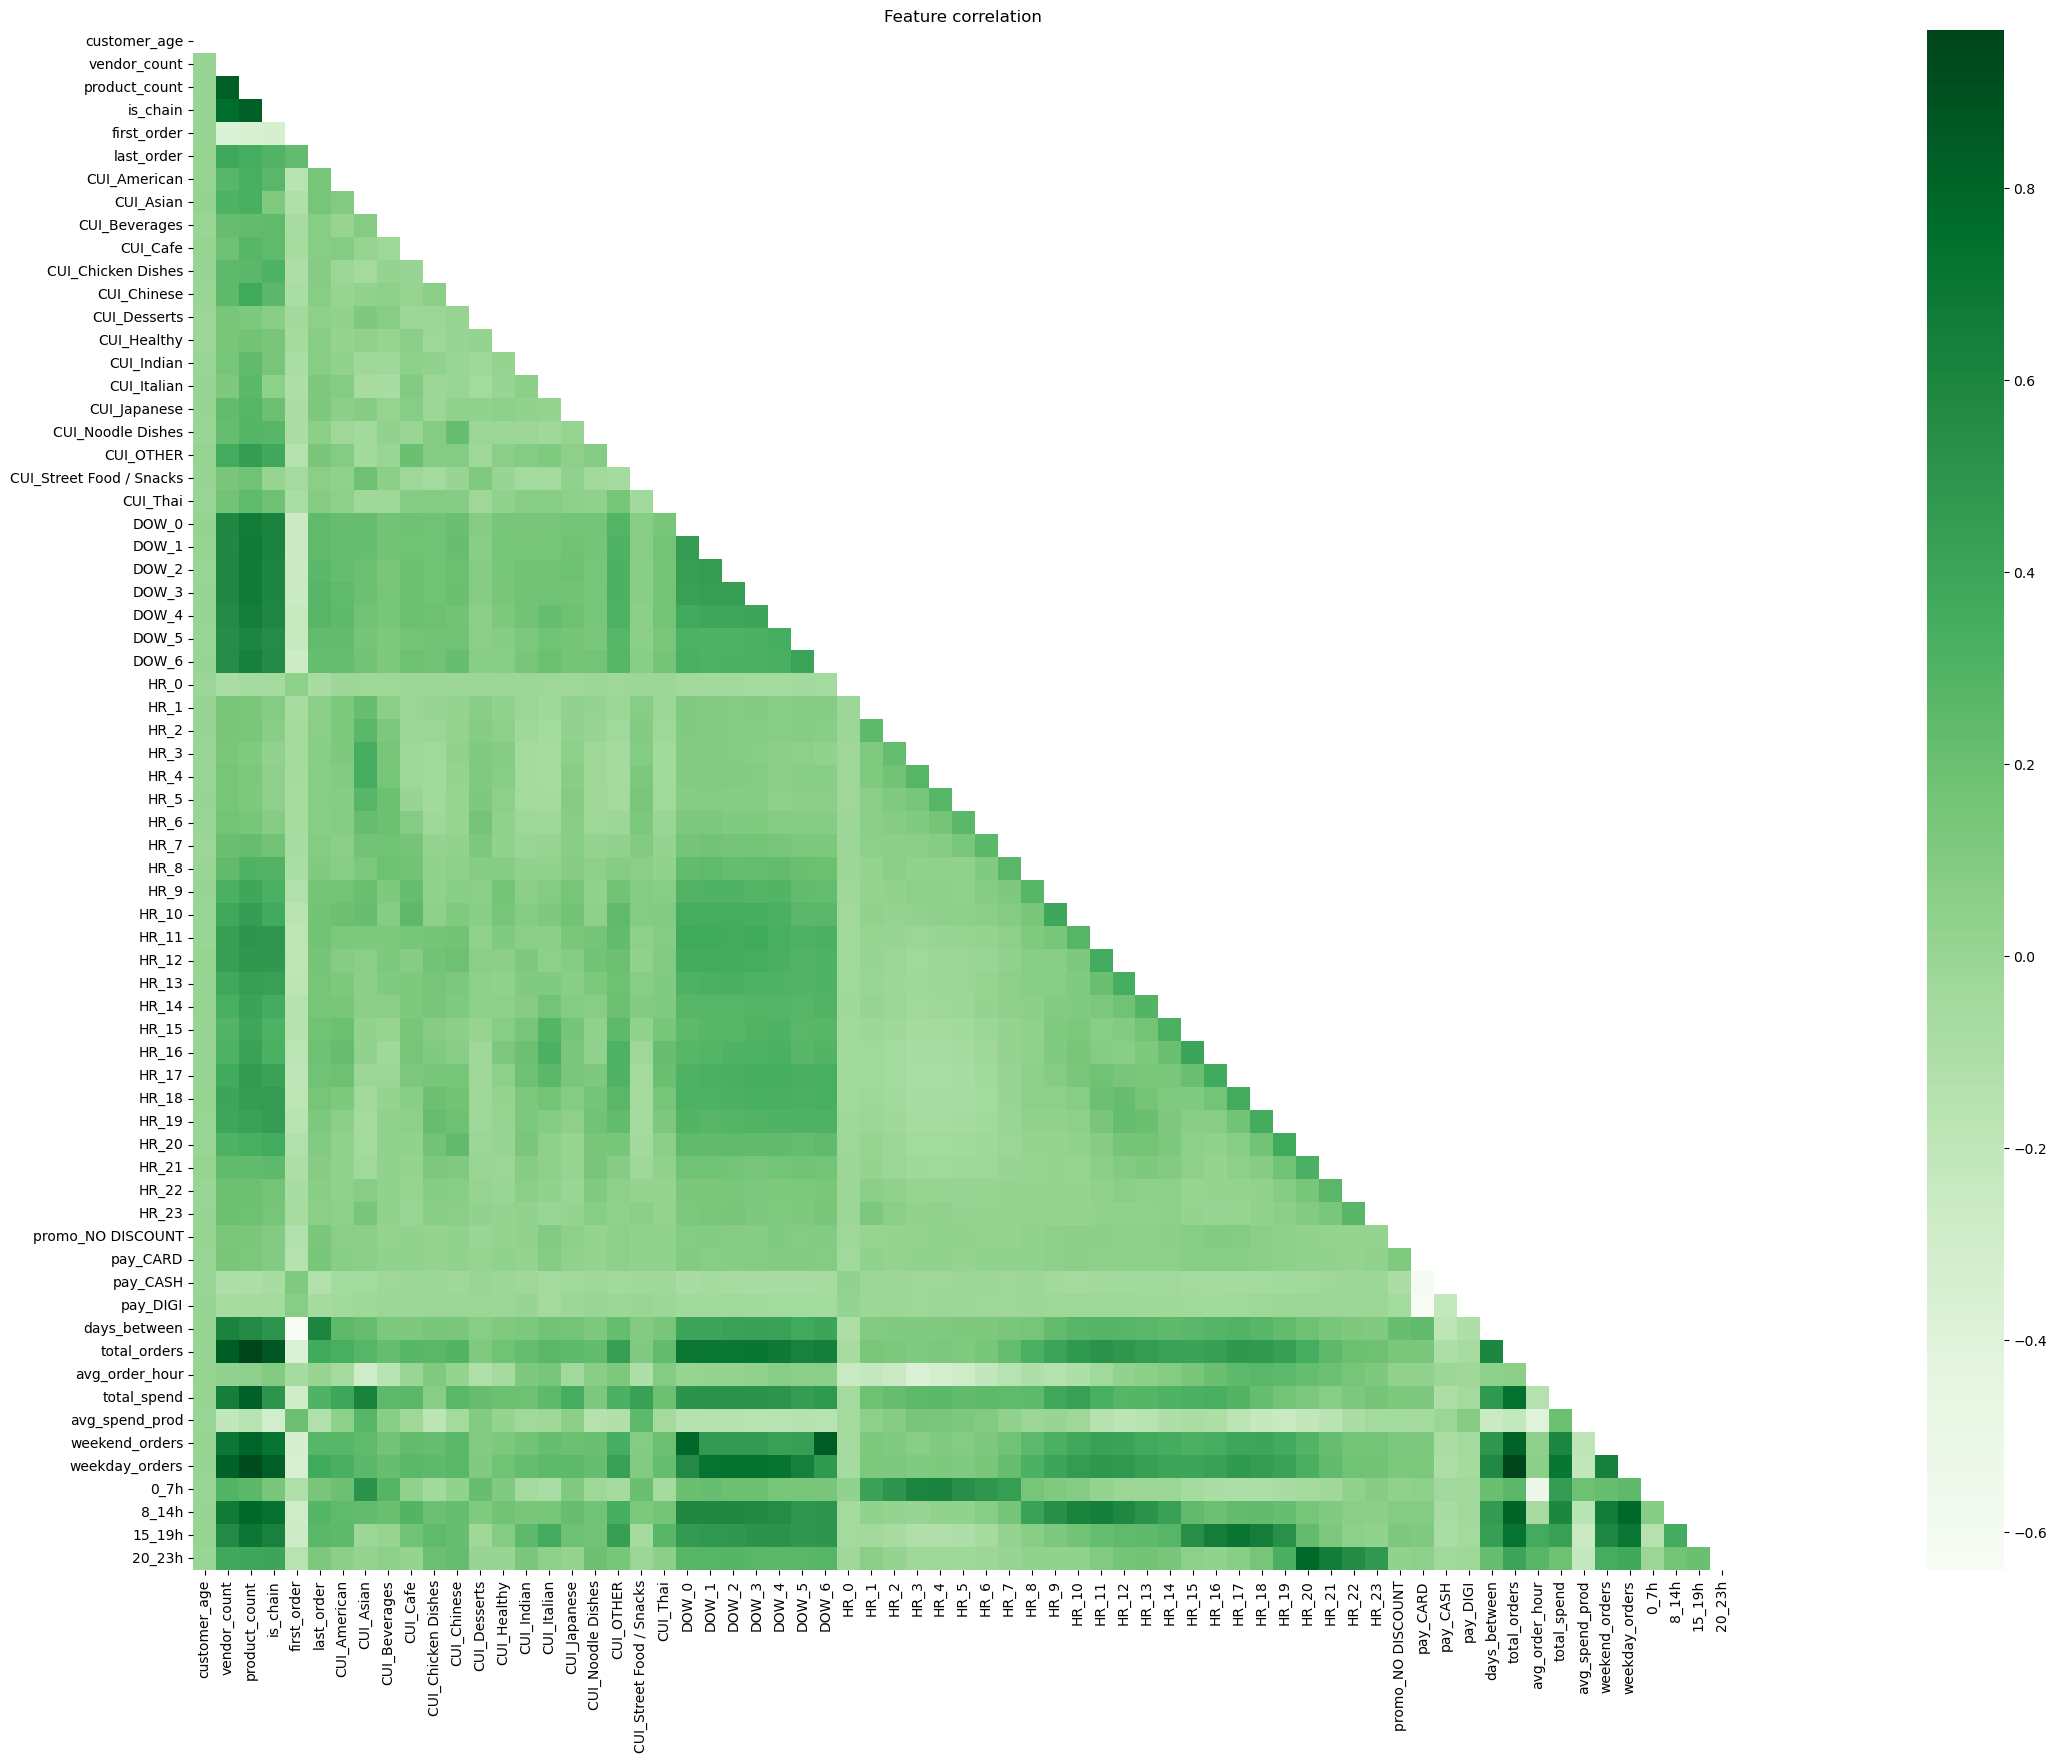

In [28]:
corr = data_num.corr(method="pearson")

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(50, 20))

sns.heatmap(data=corr, annot=True, mask=mask, cmap='Greens', fmt=".2f", square=True)

plt.title('Feature correlation')

plt.show()

Using the threshold of 0.80 (Positive and negative), there are some variables that stand out due to high correlations with several variables. The following are the variables that we can exclude due to high correlations:
* `product_count` is highly correlated to **6** variables which are: `total_orders` (0.97), `weekday_orders` (0.93), `is_chain` (0.83), `vendor_count` (0.83), `total_spend` (0.82) and `weekend_orders` (0.80).
* `total_orders` is highly correlated with **6** variables which are: `product_count` (0.97), `weekday_orders` (0.96), `is_chain` (0.87),`vendor_count` (0.83), `weekend_orders` (0.82) and`8_14h` (0.81).
* `vendor_count` is highly correlated to **3** variables which are: `total_orders` (0.84), `product_count` (0.83) and `weekday_orders` (0.81).
* `is_chain` is highly correlated to **3** variables which are: `total_orders` (0.87), `product_count` (0.83) and `weekday_orders` (0.83).
* `weekday_orders` is highly correlated with **1** variable which is `product_count` (0.93).
* `total_spend` is highly correlated with **1** variable which is `product_count` (0.82).
* `8_14h` is highly correlated with **1** variable which is `total_orders` (0.81).


Above, we can see that most of the correlations involve 2 of the variables: `product_count` and `total_orders`. As such, we should remove these variables. Additionally, we can try to train our models with and without the features `vendor_count` and `is_chain` that show high levels of correlation with 3 other variables.

<br>

## Datasets Overview

In summary we will use the following datasets:


| Dataset Name      | Notes                                                                                          |
|-------------------|------------------------------------------------------------------------------------------------|
| `data_copy`       | No outlier treatment is done                                                                   |
| `data_capped`     | Limiting outliers to fall between the interquartile range                                      |
| `data_log`        | Applying a logarithmic transformation to features that do not follow a log-normal distribution |


<br>

# 3. Data Export

<a href="#top">Top &#129033;</a>

As a final step in this notebook, we must export the treated dataset to be used in the next phase of the project.

In [29]:
#data_copy.to_csv('./data/data_copy_no_modification.csv', index = True)
#data_capped.to_csv('./data/data_capped.csv', index = True)
#data_log.to_csv('./data/data_with_log.csv', index = True)